In [1]:
from importLibrary import *
import ClassificationModel as CM

In [2]:
IMG_SIZE = (256, 256)
BATCH_SIZE = 32
seed = 11
#"C:/Users/testb/Desktop/jupyter/grapevine_leaf/Grapevine_Leaves_Image_Dataset"
all_data = tf.keras.utils.image_dataset_from_directory(
    "./Grapevine_Leaves_Image_Dataset",
    labels='inferred',
    label_mode='categorical',  # etichette one-hot
    image_size=IMG_SIZE,  # ad esempio (224, 224)
    batch_size=None  # nessun batch, ottieni tutte le immagini una per una
)

# Estrai le immagini e le etichette dal dataset
image_list = []
label_list = []

for image, label in all_data:
    image_list.append(image.numpy())  # Converti l'immagine in NumPy array
    label_list.append(label.numpy())  # Converti l'etichetta in NumPy array

# Converti le liste in array NumPy
image_array = np.array(image_list)
label_array = np.array(label_list)

print(f"image_array.shape: {image_array.shape}")
print(f"label_array.shape: {label_array.shape}")

# Primo split: ottieni training (70%) e temp (30%) per test+validation
X_train, X_temp, y_train, y_temp = train_test_split(
    image_array, label_array, test_size=0.3, stratify=label_array, random_state=seed  # 30% per validation+test
)

# Secondo split: dividi temp in validation (10%) e test (20%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.66, stratify=y_temp, random_state=seed  # 2/3 per test, 1/3 per validation
)

# Convertire i dati divisi in tf.data.Dataset
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))#.batch(BATCH_SIZE)
validation_data = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE)
test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test))#.batch(BATCH_SIZE)

Not_norm = True

Found 500 files belonging to 5 classes.
image_array.shape: (500, 256, 256, 3)
label_array.shape: (500, 5)


350
(256, 256, 3)
tf.Tensor(0.0, shape=(), dtype=float32)


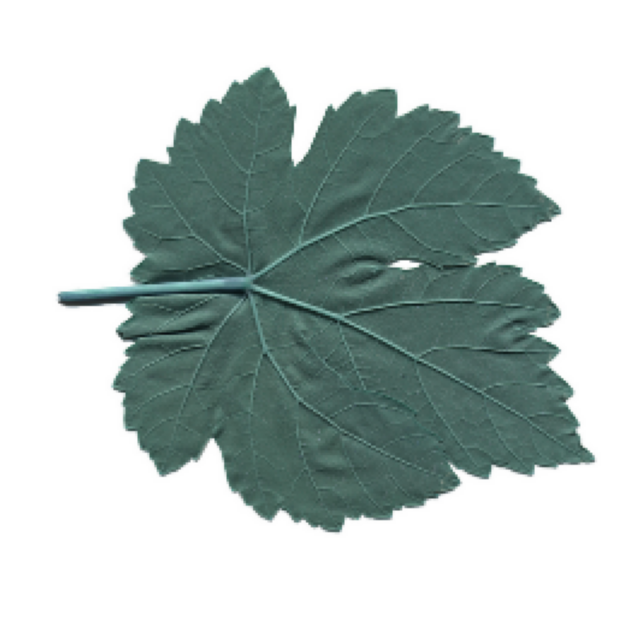

In [3]:
print(train_data.cardinality().numpy()) #num BATCH
for image_batch, labels_batch in train_data:
    print(image_batch.shape)
    print(labels_batch) # contiene one-hot delle classi
    break

img = image_batch[:,:,:].numpy().astype(np.uint8)
# Converti l'immagine da BGR a RGB (OpenCV usa BGR per default)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Crea una figura e un'asse
plt.figure(figsize=(8, 8))  # Puoi regolare le dimensioni della figura
plt.imshow(img)  # Mostra l'immagine
plt.axis('off')  # Disabilita gli assi
plt.show()  # Mostra la figura


In [4]:
# Normalizzazione - NOTA: tf.data.Dataset = img, label
if (Not_norm):
    train_data = train_data.map(lambda x, y: (x / 255.0, y))
    test_data = test_data.map(lambda x, y: (x / 255.0, y))
    Not_norm = False
    
for image_batch, labels_batch in train_data:
    print(np.min(image_batch[100,:,:].numpy()))
    print(labels_batch.numpy())
    break


0.14044684
[0. 1. 0. 0. 0.]


In [5]:
# Define a function for data augmentation
def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)  # Randomly flip the image
    image = tf.image.random_brightness(image, max_delta=0.1)  # Randomly change brightness
    # image = tf.image.random_contrast(image, lower=0.8, upper=1.2)  # Randomly adjust contrast
    return image, label
# Apply the augmentation function
augmented_data = train_data.map(augment_image)

350
(256, 256, 3)


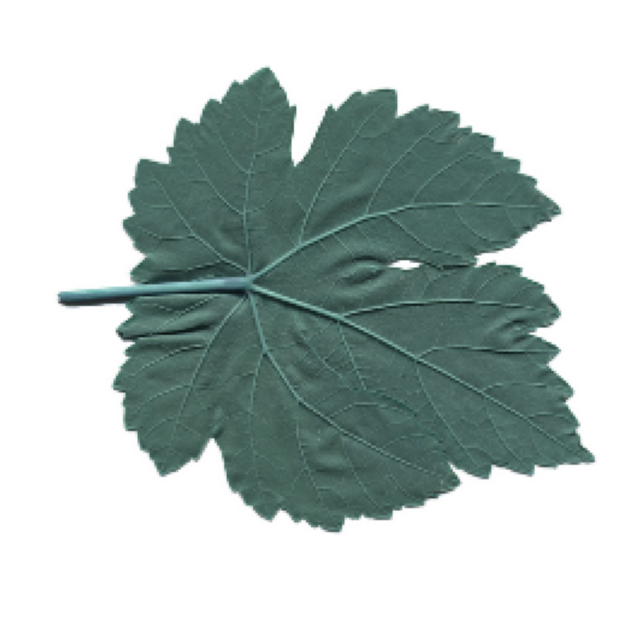

In [6]:
# Converte il dataset in un iteratore numpy
augmented_image, augmented_label = [], []
for images, labels in train_data.as_numpy_iterator():
    augmented_image.append(images)
    augmented_label.append(labels)
    
print(len(augmented_image))
print(augmented_image[0].shape)

img = augmented_image[0]#.astype(np.uint8)
# Converti l'immagine da BGR a RGB (OpenCV usa BGR per default)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Crea una figura e un'asse
plt.figure(figsize=(8, 8))  # Puoi regolare le dimensioni della figura
plt.imshow(img)  # Mostra l'immagine
plt.axis('off')  # Disabilita gli assi
plt.show()  # Mostra la figura

In [7]:
# Combiniamo i due dataset (originale e aumentato)
combined_data = train_data.concatenate(augmented_data)

# Optional: Shuffling e batching del nuovo dataset esteso
combined_data = combined_data.shuffle(buffer_size=1024).batch(BATCH_SIZE)
size =0
num_class_elem = np.zeros((1,5))
for i in combined_data:
    img,l = i
    size += img.shape[0]
    num_class_elem += np.sum(l, axis=0) 

print(size)
print(num_class_elem)

700
[[140. 140. 140. 140. 140.]]


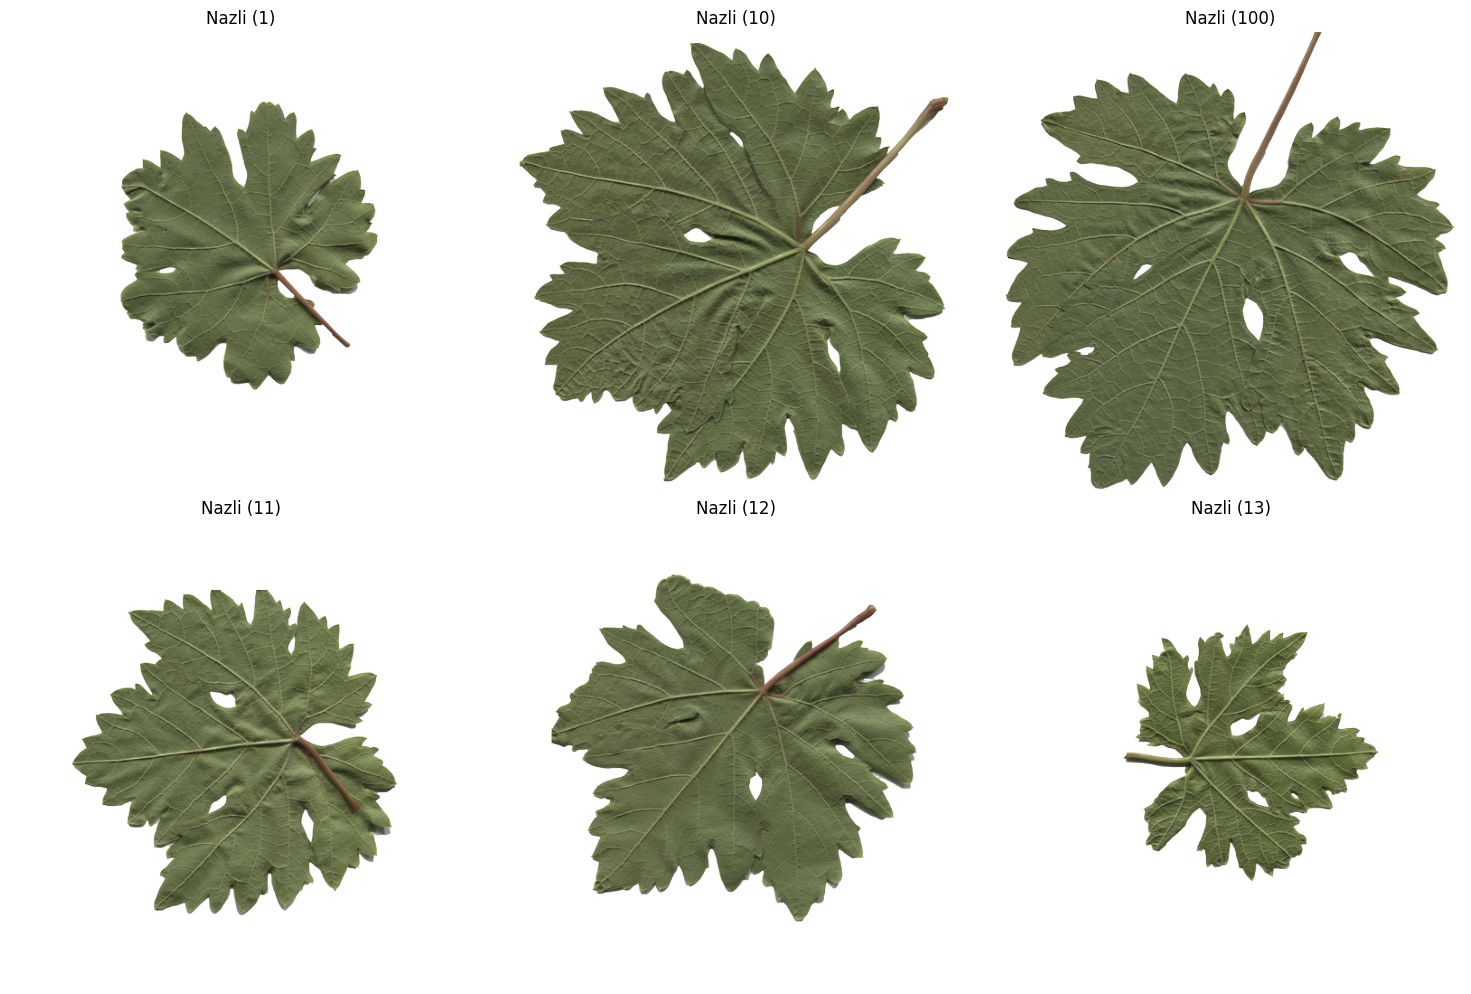

In [8]:
# Path to the directory containing images
path = "./Grapevine_Leaves_Image_Dataset/Nazli"
# Get a list of all image file names in the directory
image_files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
# Display the first 6 images with their labels
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

for i in range(6):
    # Get the image file name and its label
    image_file = image_files[i]
    label = image_file.split('.')[0]

    # Load and display the image
    img_path = os.path.join(path, image_file)
    img = mpimg.imread(img_path)
    ax = axs[i // 3, i % 3]
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(label)

plt.tight_layout()
plt.show()

In [9]:
num_classes = y_train.shape[1]
#model = CM.GenerateResModel(num_classes)
model = CM.GenerateCNN(num_classes)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    33,554,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,664,709 (128.42 MB)

 Trainable params: 33,664,709 (128.42 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:

from tensorflow.keras.callbacks import EarlyStopping

# Imposta il callback di Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',        # Metric da monitorare (ad esempio la perdita sul validation set)
    patience=5,                # Numero di epoche di pazienza (ad esempio, 5)
    restore_best_weights=True  # Ripristina i pesi con le migliori prestazioni sul validation set
)

def TrainModel(model: Model, alpha: float = 0.01, epochs: int = 20):
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=alpha), metrics=['categorical_accuracy'])
    #train_d = train_data.batch(BATCH_SIZE)
    
    history = model.fit(
        combined_data,
        epochs=epochs,
        verbose=1,
        validation_data=validation_data,  # Batch di validazione separato con dimensione diversa
        #callbacks=[early_stopping]
    )
    return history

In [11]:
# name = 'resNet_finetuned_'+str(0)
# model.save('./'+name+'.keras')
H = []
n="CNN_"
for i in range(1,21):
    print("Training ... N° " + str(i))
    if (i!=1):
        model = tf.keras.models.load_model('./'+n+str((i-1)*20)+'.keras')
    history = TrainModel(model, alpha=1e-4, epochs=20)
    H.append(history)
    name = n+str(i*20)
    model.save('./'+name+'.keras')
    

Training ... N° 1
Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - categorical_accuracy: 0.2359 - loss: 2.1653 - val_categorical_accuracy: 0.2549 - val_loss: 5.8006
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - categorical_accuracy: 0.2000 - loss: 1.6796 - val_categorical_accuracy: 0.1961 - val_loss: 4.2202
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - categorical_accuracy: 0.2158 - loss: 1.6224 - val_categorical_accuracy: 0.1961 - val_loss: 3.8201
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - categorical_accuracy: 0.2385 - loss: 1.6118 - val_categorical_accuracy: 0.2745 - val_loss: 1.6038
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - categorical_accuracy: 0.2164 - loss: 1.6093 - val_categorical_accuracy: 0.1961 - val_loss: 2.3822
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - categorical_accuracy: 0.2143 - loss: 1.6115 - val_categorical_accuracy: 0.1961 - val_loss: 2.4033
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - categorical_accuracy: 0.1740 -

KeyboardInterrupt: 

In [ ]:
H = []
n="CNN_"
for i in range(1,21):
    if (i!=0):
        M = './'+n+str((i-1)*20)
    print(M)
    print("train")
    M = n+str(i*20)

In [ ]:
# ## New training
# idx_model = 20
# model = tf.keras.models.load_model('./'+n+str(idx_model)+'.keras')
# history = TrainModel(model, alpha=1e-4, epochs=20)

In [12]:
def PlotHistory(history) -> None:
    # Plot training & validation accuracy values
    plt.plot(history.history['categorical_accuracy'], label='train accuracy') #categorical_accuracy
    # plt.plot(history.history['val_accuracy'], label='val accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'], label='train loss')
    # plt.plot(history.history['val_loss'], label='val loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

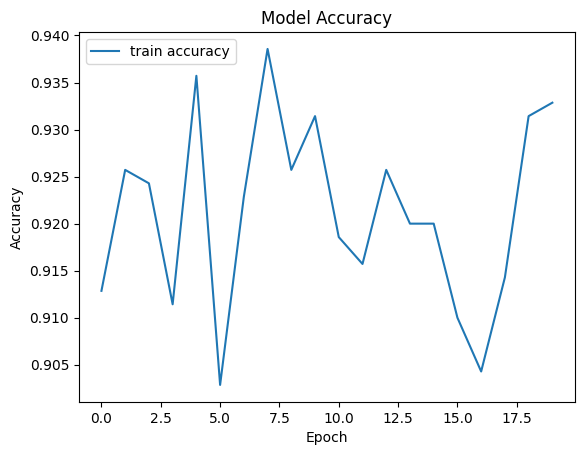

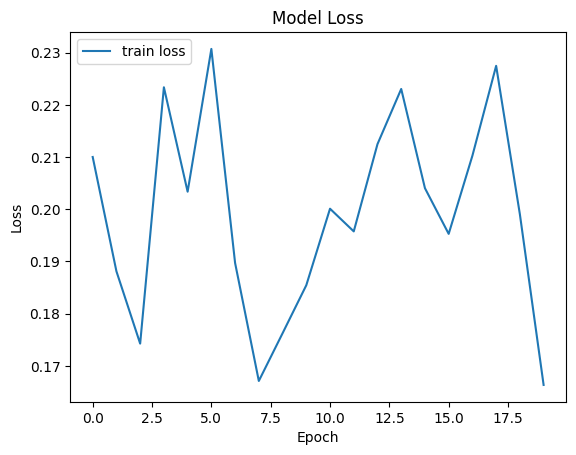

In [13]:
#PlotHistory(history)

Model Test

In [21]:
#Model to test
idx_model = 160
model = tf.keras.models.load_model('./'+n+str(idx_model)+'.keras')

In [22]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
y_pred = model.predict(X_test)
# print(y_pred)
# print(y_test)
max_indices_pred = np.argmax(y_pred, axis=1) #prediction as class number
max_indices_val = np.argmax(y_test, axis=1) #prediction as class number

def PlotMetrics(max_indices_val, max_indices_pred):
    # Create the confusion matrix
    nn_cm = confusion_matrix(max_indices_val, max_indices_pred)
    accuracy = accuracy_score(max_indices_val, max_indices_pred)
    precision = precision_score(max_indices_val, max_indices_pred, average='macro')
    recall = recall_score(max_indices_val, max_indices_pred, average='macro')
    f1 = f1_score(max_indices_val, max_indices_pred, average='macro')

    print(nn_cm)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

PlotMetrics(max_indices_val, max_indices_pred)

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 553ms/step
[[ 4  1  4  9  2]
 [ 1  3 10  4  2]
 [ 0  0 11  5  3]
 [ 0  0  6 13  1]
 [ 0  0  0  2 18]]
Accuracy: 0.494949494949495
Precision: 0.5982171591849011
Recall: 0.4957894736842105
F1 Score: 0.4566349466776046


In [15]:
model.save('./my_model.keras')

In [ ]:
loaded_model = tf.keras.models.load_model('./my_model.keras')
h = TrainModel(loaded_model)

In [ ]:
PlotHistory(history)
y_pred = model.predict(X_val)
print(y_pred)
print(y_val)
max_indices_pred = np.argmax(y_pred, axis=1) #prediction as class number
max_indices_val = np.argmax(y_val, axis=1) #prediction as class number
PlotMetrics(max_indices_pred,max_indices_val)